part 3 Algorithm testing in other crops

In [1]:
'''Import relevant libraries'''
import sys
from skimage import io,color,measure,morphology,filters,draw,segmentation,exposure,feature
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np 
from scipy import ndimage as ndi
import peakdetect as pk
import matplotlib.patches as mpatches
import time 
import matplotlib.pyplot as plt
import tqdm
import random 
import random
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn import metrics 
from xgboost import XGBClassifier
import os
  



In [2]:
# //Function1 folders creating
def file_operate():
    '''File save address'''
    try:
        BASE_DIR=os.getcwd()
        
        # Location for image reading
        IMAGE_PATH= os.path.join(BASE_DIR,"IMAGE")  
        MASK_PATH= os.path.join(BASE_DIR,"MASK") 
        # Location for saving images
        if os.path.exists(IMAGE_PATH):
            print("IMAGE_PATH file already exist")
        if os.path.exists(MASK_PATH):
            print("MASK_PATH file already exist")
        else:
            os.mkdir(IMAGE_PATH)
            os.mkdir(MASK_PATH)
            print("begain..............")
        return MASK_PATH,IMAGE_PATH
    except :
        print("There is indentation issue")
if __name__ == "__main__":
    MASK_PATH,IMAGE_PATH = file_operate()

MASK_PATH file already exist


In [3]:
# //Fuction2  Image display
def Show_Image(image, type="", label_list=""):
    '''Display image function'''
    if type == "rgb": #// RGB three channel image
        fig=plt.figure(figsize=(20,20),dpi=600)
        plt.imshow(image)
   
    elif type == "gray": # // Single channel grayscale image
        fig=plt.figure(figsize=(20,20),dpi=600)
        plt.imshow(image,cmap="gray")
    elif type == "mask": # // binary image
        fig=plt.figure(figsize=(20,20),dpi=600)
        plt.imshow(image)
    elif type == "color" :  # // Pseudo color image
        fig=plt.figure(figsize=(20,20),dpi=600)
        plt.imshow(image,cmap=plt.cm.nipy_spectral)
    elif type == "two":  # // Single canvas dual image
        fig, axes=plt.subplots(2,1,figsize=(20,2),dpi=600)
        axes[0].imshow(image[0])
        axes[0].axis('off')
        axes[1].imshow(image[1])
        axes[1].axis('off')
    elif type =="boxes": # // Regional annotation image - Pseudo color image
        fig, ax = plt.subplots(figsize=(15,5),dpi=1000)
        ax.imshow(image)
        NUM = 0
        # FONT = cv2.FONT_HERSHEY_SIMPLEX
        # FONT_SIZE =1
        # FONT_THICKNESS =2
        
        for region in (label_list):
            minr, minc, maxr, maxc = region.bbox
            NUM=NUM+1
            # draw rectangle around segmented seed
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                fill=False, edgecolor='red', linewidth=1)
        
            plt.text(region.centroid[1],region.centroid[0], NUM, ha='center', va= 'bottom', fontsize=5, color='white')
            ax.add_patch(rect)
        ax.set_axis_off()
        plt.tight_layout()
        plt.show()
if __name__ =="__main__":
    pass

In [5]:
# //Fuction3  Got mask
def get_mask(image):
    lab_image =color.rgb2lab(image)
    # plt.imshow(lab_image)
    # plt.imshow(lab_image[:,:,2])
    B_lab_image=lab_image[:,:,2]
    # plt.figure(dpi=600)
    thread=filters.threshold_otsu(B_lab_image)
    MASK=B_lab_image>thread
    MASK=morphology.remove_small_objects(MASK.astype(np.bool8),1000)
    # plt.imshow(B_lab_image>thread)
    image=morphology.closing(MASK.copy(),morphology.disk(1))
    image=morphology.opening(image.copy(),morphology.disk(1))
    label=measure.label(image)
    label_list=measure.regionprops(label)
    area=[]
    for i ,j in enumerate(label_list):
        area.append(j.area)
        # print(j.area)
    max_value=max(area)
    num=area.index(max_value)+1
    QR_region=np.where(label==num,0,1)
    # plt.imshow(np.where(label==num,0,1))
    # plt.imshow(QR_region*image)
    MASK=QR_region*image
    return MASK
if __name__ == "__main__":
   pass


In [7]:
# # //Function4 Watershed segmentation algorithm
def watershed(image,get_total_image_color=""):
    '''Using watershed algorithm to segment images'''
    #Calculate the distance from each pixel in the image to the nearest background pixel using Euclidean distance transformation
    distance = ndi.distance_transform_edt(image)
    #Find local maximum values in the distance transformed image, which will serve as marker points for the watershed algorithm
    local_max_coords = feature.peak_local_max(distance, min_distance=25)
    #Create a Boolean array with the same shape as the distance transformation image to store the positions of marker points
    local_max_mask = np.zeros(distance.shape, dtype=bool)
    #Set the position of the marker point to True
    local_max_mask[tuple(local_max_coords.T)] = True
    #Mark the marked points and generate a marked image, where each marked point has a unique label
    markers = measure.label(local_max_mask)
    #Use watershed algorithm to segment the image and return the segmented label image
    segmented_cells = segmentation.watershed(-distance, markers, mask=image)
    #Determine which form of segmentation result to return based on the value of the get_totant_image_color parameter
    if get_total_image_color == True:
        #Convert the segmented label image into a color image and add labels to each region
        color_image=color.label2rgb(segmented_cells, bg_label=0)
        COLOR_IMAGE=color_image.copy()
        font=cv.FONT_HERSHEY_SIMPLEX
        font_size=1
        font_thickness=2
        label_list=measure.regionprops(segmented_cells)
        for i,region in enumerate(label_list):
            #Add labels to each region, with the label text being the region's serial number
            text=str(i+1)
            minr, minc, maxr, maxc = region.bbox
            color_image=cv.putText(COLOR_IMAGE, text, (int(region.centroid[1]),int(region.centroid[0])), font, font_size, (0, 0, 0), font_thickness)
            seg_image=np.logical_or(COLOR_IMAGE,color_image)
    if get_total_image_color == False:
        #Use the mark_foundaries function to mark segmentation boundaries on the original image
        edge=segmentation.mark_boundaries(image,segmented_cells)
        #Create a completely black image with the same shape as the original image, but only retain the positions 
        #  of non-zero pixels in the original image as white (the logic seems to be incorrect here, as this image was not ultimately used)
        image_merge=cv.merge([np.where(image>0,255,0),np.where(image>0,255,0),np.where(image>0,255,0)])
        edge = np.logical_xor(edge,image_merge)
        seg_image = np.where(color.rgb2gray(edge)>0,0,1)*image
    #Return the segmented image
    return seg_image
    
if __name__ == "__main__":
    pass
    

In [8]:
# # //Function5  Finally, calculate the area of each label, take the area of two or three seeds, 
# and calculate the convex hull to obtain convex defects. The graph defects are used to segment the remaining seeds

def Convex_defects(image):
    '''Obtain convex defects'''
    #Label the image and assign a unique label to each connected region
    label_image=measure.label(image)
    #Calculate the area of each connected region
    area=[]
    for region in (measure.regionprops(label_image)):
        area.append(region.area)
    #Remove small objects smaller than 1.25 times the median area
    image_remove_smallbold=morphology.remove_small_objects(image.astype(np.bool8),int(np.median(area))*1.25)
    #Calculate the convex hull of each object
    image_convex=morphology.convex_hull_object(image_remove_smallbold, connectivity=1)
    #Calculate the convex defect area (i.e. the part outside the convex hull)
    image_convexity=np.logical_xor( image_remove_smallbold,image_convex)
    #Remove small convex defect areas smaller than 500 pixels
    image_convexity=morphology.remove_small_objects(image_convexity.astype(np.bool8),500)
    #Perform an open operation on the convex defect area to remove small noise points
    image_convexity=morphology.opening(image_convexity,morphology.disk(1))
    return image_convexity,image_convex,image_remove_smallbold

def get_min_point(contour1,contour2):
    #Using Harris corner detection algorithm to detect the corners of two contours
    coords11=feature.corner_peaks(feature.corner_harris(contour1), min_distance=5,threshold_rel=0.02)
    coords22=feature.corner_peaks(feature.corner_harris(contour2),min_distance=5,threshold_rel=0.02)
    min_distance=sys.maxsize
    #Calculate the minimum distance between two contour corner points
    for i in range(len(coords11)):
        for j in range (len(coords22)):
            distance=pow(((coords11[i][0]-coords22[j][0])**2+(coords11[i][1]-coords22[j][1])**2),0.5)
            if (distance<min_distance):
                min_distance=distance
                index111=i
                index222=j
    return  coords11[index111], coords22[index222]

def contour(label,number):
    '''Extract corresponding contour regions based on tag values'''
    contour=np.where(label==number+1,1,0)
    return contour
def Contour_index(image):
    ''''Obtain the nearest point coordinates and index of each convex defect corner point'''
    #Label the image and obtain the attributes of each connected region
    # image=morphology.remove_small_objects(image.astype(np.bool8),70)
    label=measure.label(image)
    label_list=measure.regionprops(label)
    #Initialize coordinate list
#     min_distance=sys.maxsize
    coord_list_x=[]
    coord_list_y=[]
    #Traverse each connected region and calculate the nearest corner distance to other regions
    for index_x,region in enumerate (label_list.copy()):
        # min_distance=sys.maxsize
        contour1=contour(label,index_x)
        Distance=[]
        left_coord=[]
        right_coord=[]
        for index_y,regions in enumerate(label_list.copy()):
          
            #Get the closest corner points of two contours
            contour2=contour(label,index_y)
            # coords_x, coords_y,index_1,index_2 =get_min_point(contour1,contour2)
            # distance=pow(((coords_x[0]-coords_y[0])**2+(coords_x[1]-coords_y[1])**2),0.5)
            if np.sum(contour1-contour2)==0:
                continue    
            else:
                coords11=feature.corner_peaks(feature.corner_harris(contour1), min_distance=5,threshold_rel=0.02)
                coords22=feature.corner_peaks(feature.corner_harris(contour2),min_distance=5,threshold_rel=0.02)
                min_distance_region=sys.maxsize
                for i in range(len(coords11)):
                    for j in range (len(coords22)):
                        distance=pow(((coords11[i][0]-coords22[j][0])**2+(coords11[i][1]-coords22[j][1])**2),0.5)
                        if (distance<min_distance_region):
                            min_distance_region=distance
                            index111=i
                            index222=j
                # print(coords11[index111])
                left_coord.append(coords11[index111])
                right_coord.append(coords22[index222])
        for i,j in enumerate( left_coord):
            Distance.append(pow((( right_coord[i][0]-left_coord[i][0])**2+( right_coord[i][1]-left_coord[i][1])**2),0.5))
        # print(Distance)
        if Distance == []:
            continue
        index=Distance.index(min(Distance))
        coord_x=left_coord[index]
        coord_y=right_coord[index]
        coord_list_x.append(coord_x)
        coord_list_y.append(coord_y)
        #Calculate and store the nearest distance
        # ... (Omitted some code)
    return coord_list_x,coord_list_y
#  Note that if there are too many convex defect areas, in order to reduce the time complexity of the algorithm,
#  the nearest corner points can be calculated sequentially for each convex hull area
def Contour_index_single(image_convexity,image_convex):
    '''Label the convex hull image and obtain the attributes of each connected region
      Calculate the nearest corner point between each convex hull region and the convex defect region'''
    label=measure.label(image_convex)
    label_list=measure.regionprops(label)
    X=[]
    Y=[]
    for i,j in enumerate(label_list):

        #Single convex hull region
        Singer_convex=contour(label,i)
        Contour=np.logical_and(Singer_convex,image_convexity)
        # plt.imshow(Contour)
        left_coord,right_coord=Contour_index(Contour)
        # print(left_coord)
        X.append(left_coord)
        Y.append(right_coord)
    return sum(X,[]),sum(Y,[]) 
def seg_images(left_coord,right_coord,MASK):
    '''Obtain the segmented image, where the parameters are 
    the set of corner coordinates of the nearest convex defect area'''
    #Draw a segmentation line based on the coordinates of the nearest corner and segment the image
    #Post process the segmented image and remove small areas
    for i,j  in enumerate(right_coord):
        # print(right_coord[i])
        rr, cc,val = draw.line_aa(left_coord[i][0],left_coord[i][1],right_coord[i][0], right_coord[i][1])
        line_image=MASK
        line_image[rr, cc] =255
        seg_image=np.where(line_image==255,0,1)*MASK  
    label_image=measure.label(seg_image)
    area=[]
    for region in (measure.regionprops(label_image)):
        area.append(region.area)
    seg_image_1=morphology.remove_small_objects(seg_image.astype(np.bool8),int(np.median(area))*0.1)   
    seg_image_2=morphology.remove_small_objects(seg_image.astype(np.bool8),int(np.median(area))*1.5) 
    seg_image=np.logical_xor(seg_image_1,seg_image_2)  
    # show_image(seg_image)
    return seg_image
if __name__ == "__main__": 
    pass
    
        

In [10]:
########################################################################
##                 <Algorithm running main program>                   ##                                                
########################################################################

if __name__ == "__main__":
    try:
        ## ##############/////Step 1 : Obtain the mask for the seed area
        watershed = "False"
        RICE_IMAGE_PATH = os.path.join(
            os.path.join(os.path.dirname(os.getcwd()),os.listdir(os.path.dirname(os.getcwd()))[0]),\
            os.listdir( os.path.join(os.path.dirname(os.getcwd()),os.listdir(os.path.dirname(os.getcwd()))[0]))[3]) 
        RICE_IMAGE=io.imread(RICE_IMAGE_PATH)
        MASK1=get_mask(RICE_IMAGE)
         ## ##############/////Step 2 : Based on adhesive region segmentation
        image_convexity,image_convex,image_remove_smallbold=Convex_defects(MASK1)
        left_coord,right_coord=Contour_index_single(image_convexity,image_convex)
        if left_coord != []:
            MASK2=seg_images(left_coord,right_coord,MASK1)
        elif watershed == "True":
            get_total_image_color = False
            MASK2= watershed(MASK1,get_total_image_color)
        else: 
            MASK2=MASK1.copy()

    except IOError :
        print("File not read, please re-enter")

        

In [ ]:
###################################################################
#                    END of the algorithm                         #
###################################################################

In [ ]:
###################################################################
#                   Image processing process                      #
###################################################################

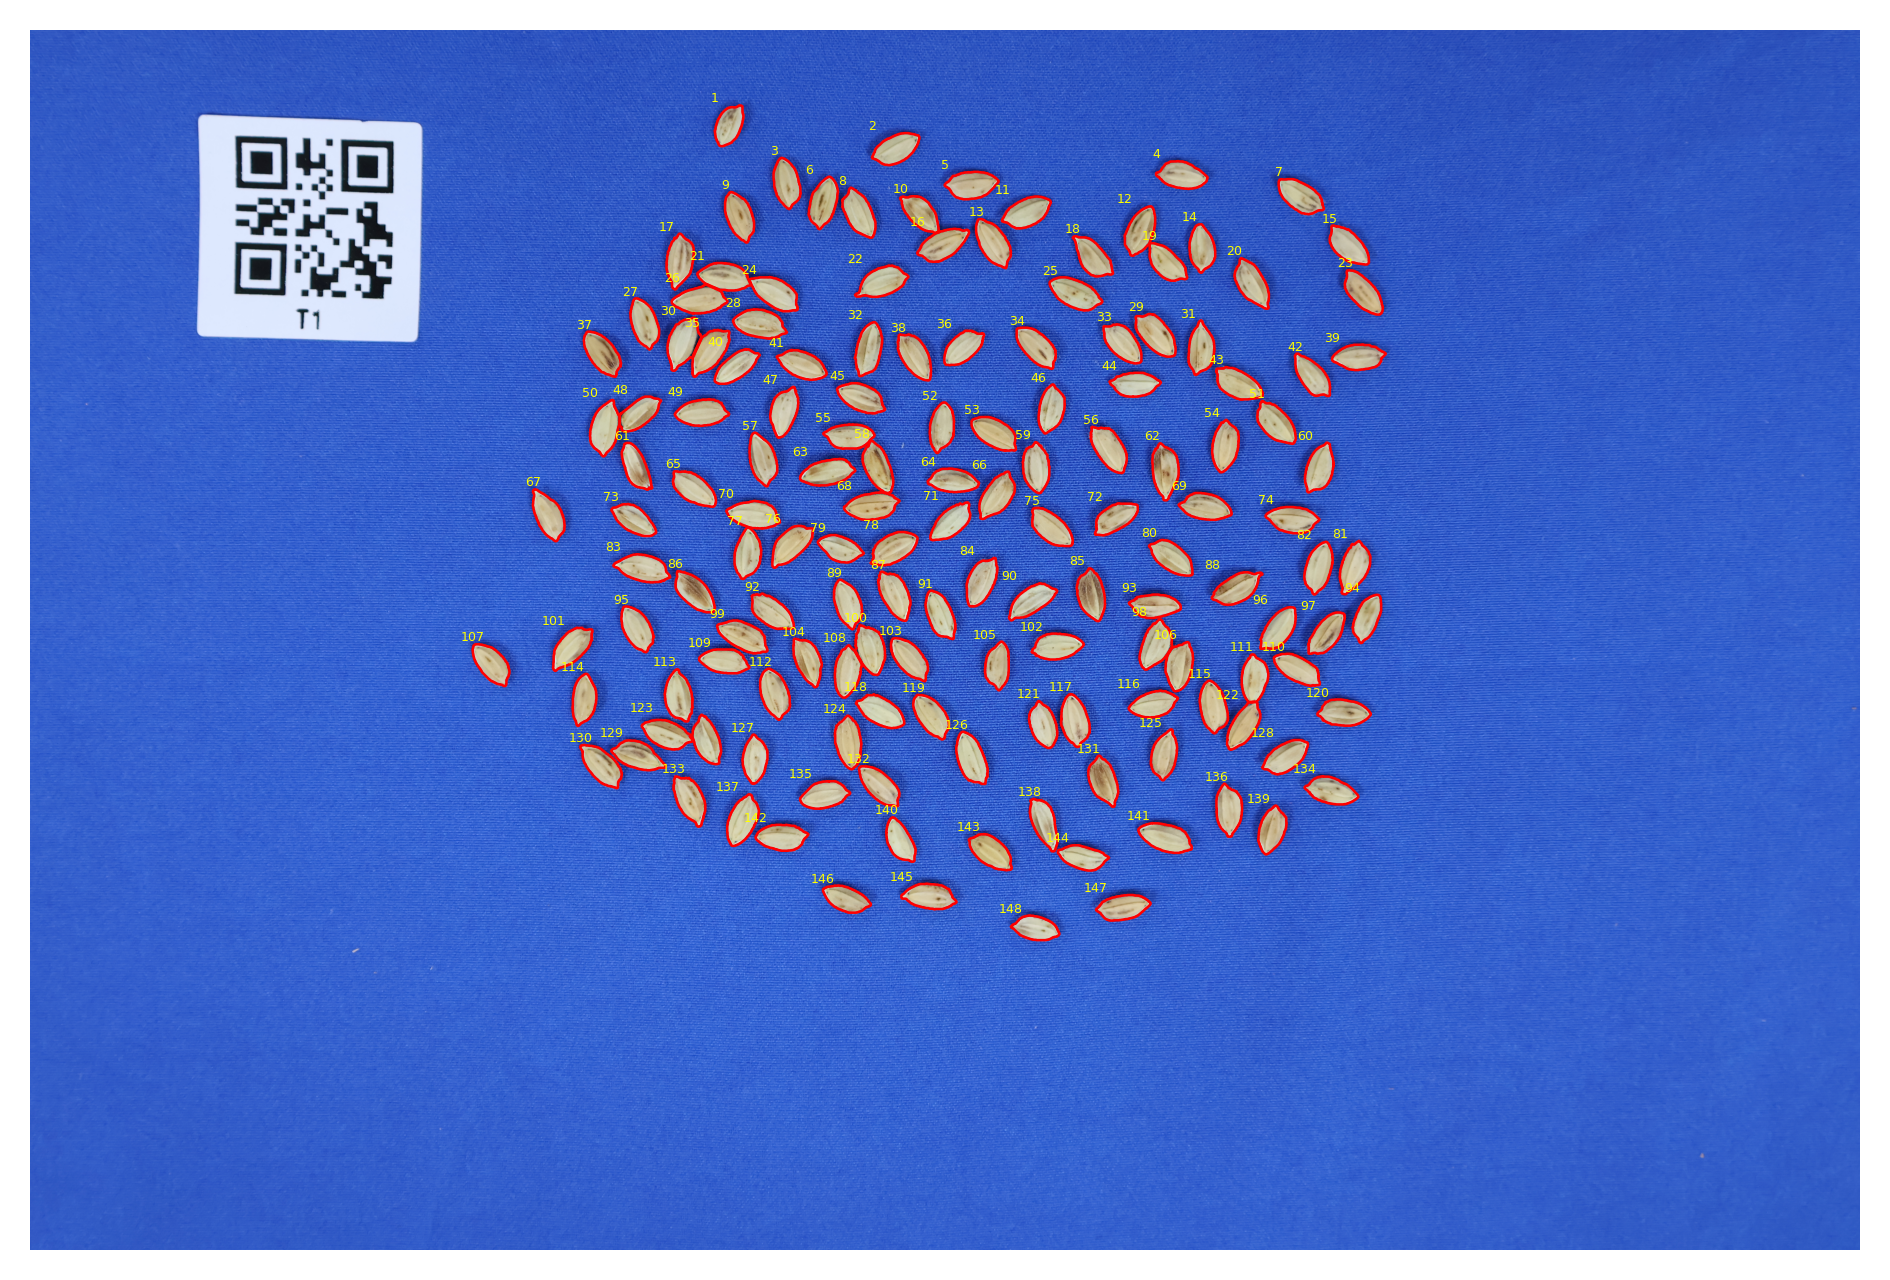

In [17]:
""" Display of segmented images"""
label_list=measure.regionprops(measure.label(MASK2))
fig, ax = plt.subplots(dpi=300)
ax.imshow(RICE_IMAGE)
num=0
for region in (label_list):
    if region.area >1000:
        minr, minc, maxr, maxc = region.bbox
        num=num+1
        plt.text(minc, minr, num, ha='center', va= 'bottom',fontsize=3, color='yellow')
ax.set_axis_off()
plt.tight_layout()
plt.contour(MASK2,colors="red",linewidths=.6)
plt.show()

In [ ]:
###################################################################
#                      END of Image processing                    #
###################################################################